# Auswertung der Eyetrackingdaten

## Einleitung

Dieses Notebook umfasst die Exploration und erste Auswertung der Eyetrackingdaten, welche im Rahmen der Experimente für den Kurs *Algorithmen für Mensch-Maschine-Interaktion* im Zeitraum vom 25.02.2019 - 01.03.2019 aufgezeichnet wurden. Die Probanden wurden während des Experiments mit einer Kamera gefilmt. Mit Hilfe der [OpenFace](https://github.com/TadasBaltrusaitis/OpenFace) Bibliothek wurden die Kamerabilder dann direkt ausgewertet. Diese Auswertungen liegen als CSV-Dateien vor und beinhalten unter anderem die Koordinaten bestimmter Gesichtslandmarken, sowie die Blickrichtung  im Kamerakoordinatensystem (vgl. [Output Format OpenFace](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Output-Format)).


## Exploration

Zunächst werden die aufgezeichneten Daten exploriert. Im ersten Schritt werden die für das Notebook benötigten Bibliotheken importiert.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
import math
from ipywidgets import interactive, IntSlider, FloatSlider

Um einen ersten Einblick in die Struktur der Daten zu bekommen, werden die CSV Dateien eingelesen und hinsichtlich der Länge und der Dauer bzw. Anzahl der analysierten Kameraframes untersucht. Zuerst werden alle Pfade der relevanten CSV Dateien in einer Liste gespeichert.

In [2]:
# siehe https://stackoverflow.com/questions/19587118/iterating-through-directories-with-python

root = './0_sorted'
file_names = []

for subdir, dirs, files in os.walk(root):
    for file in files:
        if 'webcam_2019' not in file or '.csv' not in file:
            continue
        file_names.append(os.path.join(subdir, file).replace('\\', '/'))

Im nächsten Schritt werden die Dateien mit der *pandas* Bibliothek als Dataframe eingelesen. Für jede Datei wird dann die Anzahl der aufgezeichneten Frames, die Dauer der Aufnahme in Sekunden, die Anzahl der Frames mit erkanntem Gesicht, die Anzahl der Frames mit erkanntem Blick und der Dateipfad ausgegeben. Die Dauer der Aufnahme entspricht dabei dem Timestamp des letzten Frames. Die Anzahl der Frames mit erkanntem Gesicht wird mit Hilfe der Gesichtslandmarke *eye_lmk_0* berechnet, also alle Frames, bei denen die x, y und z Koordinaten dieser Landmarke nicht gleichzeitig null sind. Die Anzahl der Frames mit erkanntem Blick wird mit Hilfe der Spalten zum *gaze_0* Wert errechnet, also alle Frames, bei denen die x, y und z Koordinaten des *gaze_0* Vektors nicht gleichzeitig null sind. (vgl. [Output Format OpenFace](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Output-Format))

In [3]:
info_titles = [
    'Frames',
    'Dauer (s)',
    'Frames mit Gesicht',
    'Frames mit Blick',
    'Dateipfad'
]

info_data = []
for f in file_names:
    df = pd.read_csv(f, sep=', ', engine='python')
    count_total = len(df['frame'])
    last_ts = df['timestamp'][count_total - 1]
    count_face = len(df[(df[['eye_lmk_X_0','eye_lmk_Y_0','eye_lmk_Z_0']] != 0).all(axis=1)]['frame'])
    count_gaze = len(df[(df[['gaze_0_x','gaze_0_y','gaze_0_z']] != 0).all(axis=1)]['frame'])
    info_data.append([count_total, last_ts, count_face, count_gaze, f])
    
pd.DataFrame(info_data, columns=info_titles)

,Frames,Dauer (s),Frames mit Gesicht,Frames mit Blick,Dateipfad
0,7360,5974.273,7360,772,./0_sorted/3_thursday/webcam_2019-02-28-11-11.csv
1,38323,NaN,38323,1282,./0_sorted/3_thursday/webcam_2019-02-28-13-16.csv
2,10419,4383.042,10419,434,./0_sorted/2_wednesday/webcam_2019-02-27-14-57...
3,10542,4661.934,10541,405,./0_sorted/2_wednesday/webcam_2019-02-27-11-10...
4,1918,238.706,1918,9,./0_sorted/2_wednesday/webcam_2019-02-27-13-00...
5,2095,2957.093,2094,426,./0_sorted/2_wednesday/webcam_2019-02-27-13-06...
6,4922,4682.726,4922,758,./0_sorted/4_friday/webcam_2019-03-01-13-02.csv
7,1968,221.135,1968,85,./0_sorted/4_friday/webcam_2019-03-01-11-00.csv
8,4273,4249.251,4273,407,./0_sorted/4_friday/webcam_2019-03-01-11-08.csv
9,21546,14153.174,21542,948,./0_sorted/1_tuesday/webcam_2019-02-26-11-00.csv


Für die weitere Exploration wird der Datensatz *./2_raw/2019-02-27/webcam_2019-02-27-14-57.csv* verwendet, da dieser die meisten aufgezeichneten Frames und Frames mit erkanntem Gesicht beinhaltet.

Es werden zunächst die Plotfunktionen definiert, welche im weiteren Verlauf noch benötigt werden. Dabei werden immer drei Diagramme in einer Zeile angezeigt, wobei das erste die X-Y, das zweite die X-Z und das dritte Diagramm jeweils die Z-Y Ebene darstellen.

In [5]:
def get_sub_plots(title):
    fig = plt.figure(1, figsize=(20, 5))

    sp1 = fig.add_subplot(131)
    sp1.set_title("X - Y")
    sp1.set_xlabel('X - Koordinaten')
    sp1.set_ylabel('Y - Koordinaten')

    sp2 = fig.add_subplot(132)
    sp2.set_title("X - Z")
    sp2.set_xlabel('X - Koordinaten')
    sp2.set_ylabel('Z - Koordinaten')

    sp3 = fig.add_subplot(133)
    sp3.set_title("Z - Y")
    sp3.set_xlabel('Z - Koordinaten')
    sp3.set_ylabel('Y - Koordinaten')

    plt.suptitle(title)
    
    return sp1, sp2, sp3

def show_images(sp1, sp2, sp3):
    img1=mpimg.imread('front.jpg')
    sp1.imshow(img1,origin='lower')

    img2=mpimg.imread('top.jpg')
    sp2.imshow(img2,origin='lower')

    img3=mpimg.imread('side.jpg')
    sp3.imshow(img3,origin='lower')

    # farben von vektoren setzen
def get_vector_colors(colors, size):
    if colors == None:
        colors = [['r','g']] * size
    return colors

#plottet die linien der vektoren / draw function
def add_vectors(sp, start_x, end_x, start_y, end_y, colors, start_fmt, line_width):
    lines = sp.plot([start_x, end_x], [start_y, end_y], '-', linewidth=line_width, markersize=0)
    for i in range(len(colors)):
        lines[i].set_color(colors[i][0])
    lines = sp.plot([start_x, start_x], [start_y, start_y], start_fmt, markersize=4)
    for i in range(len(colors)):
        lines[i].set_color(colors[i][1])
        
# AOIs
def add_rect(sp, x, y, w, h, color):
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor=color, facecolor=color)
    sp.add_patch(rect)

# Punkte zeichnen
def plot(coords, title):
    sp1, sp2, sp3 = get_sub_plots(title)
    
    sp1.scatter(x=coords[0], y=coords[1], c='r', s=1)
    sp2.scatter(x=coords[0], y=coords[2], c='r', s=1)
    sp3.scatter(x=coords[2], y=coords[1], c='r', s=1)
    
    plt.show()
    
def plot_with_image(coords, title):
    sp1, sp2, sp3 = get_sub_plots(title)
    
    sp1.scatter(x=coords[0], y=coords[1], c='r', s=1)
    sp2.scatter(x=coords[0], y=coords[2], c='r', s=1)
    sp3.scatter(x=coords[2], y=coords[1], c='r', s=1)
    
    show_images(sp1, sp2, sp3)
    
    plt.show()
    
def plot_vectors(start, end, title, start_fmt='x', line_width=0.5, colors=None):
    colors = get_vector_colors(colors, len(start[0]))
    
    sp1, sp2, sp3 = get_sub_plots(title)
    
    add_vectors(sp1, start[0], end[0], start[1], end[1], colors, start_fmt, line_width)
    add_vectors(sp2, start[0], end[0], start[2], end[2], colors, start_fmt, line_width)
    add_vectors(sp3, start[2], end[2], start[1], end[1], colors, start_fmt, line_width)
    
    plt.show()
    
def plot_vectors_with_image(start, end, title, start_fmt='x', line_width=0.5, colors=None):
    colors = get_vector_colors(colors, len(start[0]))
    
    sp1, sp2, sp3 = get_sub_plots(title)
    
    add_vectors(sp1, start[0], end[0], start[1], end[1], colors, start_fmt, line_width)
    add_vectors(sp2, start[0], end[0], start[2], end[2], colors, start_fmt, line_width)
    add_vectors(sp3, start[2], end[2], start[1], end[1], colors, start_fmt, line_width)
    
    show_images(sp1, sp2, sp3)
    
    plt.show()
    
def plot_vectors_with_image_and_aois(start, end, aois, title, start_fmt='x', line_width=0.5, colors=None):
    colors = get_vector_colors(colors, len(start[0]))
    
    sp1, sp2, sp3 = get_sub_plots(title)
    
    add_vectors(sp1, start[0], end[0], start[1], end[1], colors, start_fmt, line_width)
    add_vectors(sp2, start[0], end[0], start[2], end[2], colors, start_fmt, line_width)
    add_vectors(sp3, start[2], end[2], start[1], end[1], colors, start_fmt, line_width)
    
    for aoi in aois:
        add_rect(sp1, aoi.x, aoi.y, aoi.w, aoi.h, aoi.color)
        add_rect(sp2, aoi.x, aoi.z, aoi.w, aoi.d, aoi.color)
        add_rect(sp3, aoi.z, aoi.y, aoi.d, aoi.h, aoi.color)
        
    show_images(sp1, sp2, sp3)

    plt.show()
    
def plot_heatmap(aoi, title):
    sp1, sp2, sp3 = get_sub_plots(title)
    
    add_rect(sp1, aoi.x, aoi.y, aoi.w, aoi.h, aoi.color)
    add_rect(sp2, aoi.x, aoi.z, aoi.w, aoi.d, aoi.color)
    add_rect(sp3, aoi.z, aoi.y, aoi.d, aoi.h, aoi.color)
    
    if len(aoi.points) > 0:
        points = np.swapaxes(np.array(aoi.points), 0, 1)

        sp1.scatter(x=points[0], y=points[1], c=[[1, 0, 0, 0.2]], s=50, zorder=2)
        sp2.scatter(x=points[0], y=points[2], c=[[1, 0, 0, 0.2]], s=50, zorder=2)
        sp3.scatter(x=points[2], y=points[1], c=[[1, 0, 0, 0.2]], s=50, zorder=2)
        
    show_images(sp1, sp2, sp3)
    
    plt.show()

Für die erste Darstellung der Daten wird der Datensatz eingelesen und es wird die Gesichtslandmarke *eye_lmk_0* geplottet. Die Koordinaten sind dabei im Kamerakoordinatensystem angegeben (vgl. [Output Format OpenFace](https://github.com/TadasBaltrusaitis/OpenFace/wiki/Output-Format)):
- X-Achse: von links nach rechts - links negativ, mitte 0, rechts positiv
- Y-Achse: von unten nach oben - unten negativ, mitte 0, oben positiv
- Z-Achse: berechnete Tiefe - 0 = Position der Kamera, je höher der Wert, desto weiter weg

In [6]:
df = pd.read_csv('./2_raw/2019-02-27/webcam_2019-02-27-14-57.csv', sep=', ', engine='python')

face_df = df[(df[['eye_lmk_X_0','eye_lmk_Y_0','eye_lmk_Z_0']] != 0).all(axis=1)]
gaze_df = df[(df[['gaze_0_x','gaze_0_y','gaze_0_z']] != 0).all(axis=1)]

COORDS_FACE = np.array([face_df['eye_lmk_X_0'], face_df['eye_lmk_Y_0'], face_df['eye_lmk_Z_0']])
COORDS_GAZE = np.array([gaze_df['eye_lmk_X_0'], gaze_df['eye_lmk_Y_0'], gaze_df['eye_lmk_Z_0']])

GAZES = np.array([gaze_df['gaze_0_x'], gaze_df['gaze_0_y'], gaze_df['gaze_0_z']])

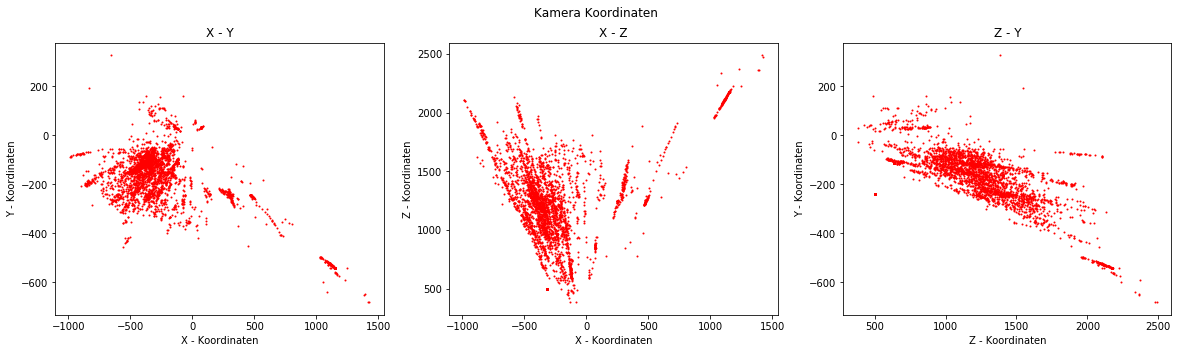

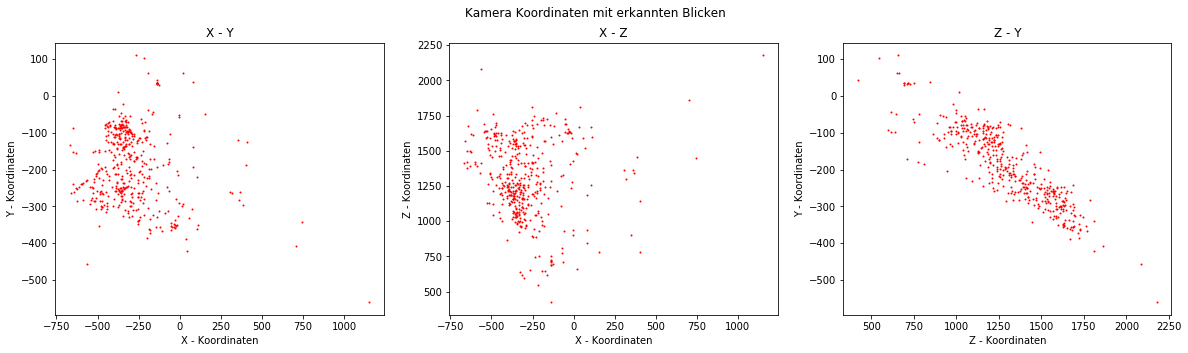

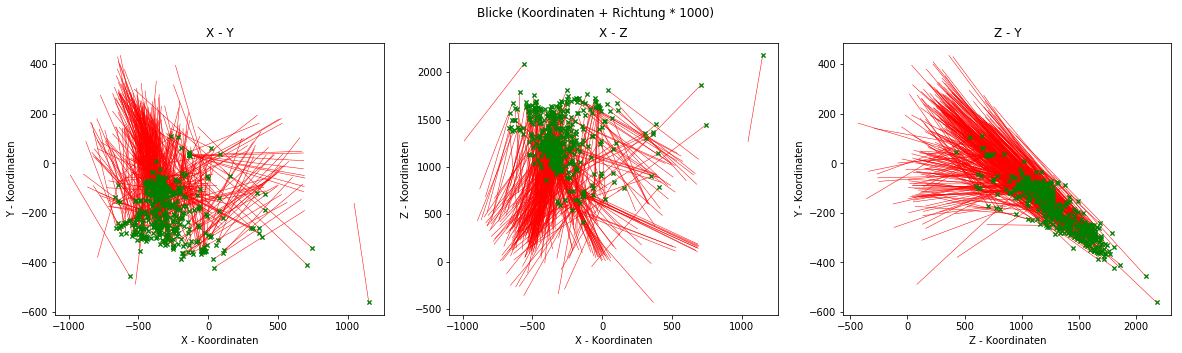

In [7]:
### Erster Plot ###
plot(COORDS_FACE, 'Kamera Koordinaten')

### Zweiter Plot ###
plot(COORDS_GAZE, 'Kamera Koordinaten mit erkannten Blicken')

### Dritter Plot ###
# Achsen umdrehen für Berechnung: soll -> [[x1,y1,z1],[x2,y2,z2],...] ist -> [[x1,x2,...],[y1,y2,...],[z1,z2,...]]
gaze_ends = np.swapaxes(np.swapaxes(COORDS_GAZE, 0, 1) + np.swapaxes(GAZES, 0, 1) * 1000, 0, 1)
plot_vectors(COORDS_GAZE, gaze_ends, 'Blicke (Koordinaten + Richtung * 1000)')

Damit die Kamerakoordinaten in das Koordinatensystem des erstellten 3D Models überführt werden können, müssen zunächst die Funktionen für die elementaren Transformationen für 3D Koordinaten definiert werden.

In [8]:
# siehe https://de.wikipedia.org/wiki/Abbildungsmatrix
#       https://de.wikipedia.org/wiki/Koordinatentransformation
#       https://de.wikipedia.org/wiki/Homogene_Koordinaten
#       https://de.wikipedia.org/wiki/Drehmatrix

def translate(x, y, z):
    return np.array([
        [1, 0, 0, x],
        [0, 1, 0, y],
        [0, 0, 1, z],
        [0, 0, 0, 1]
    ])

def rotate_x(phi):
    return np.array([
        [1, 0,        0,         0],
        [0, math.cos(phi), -math.sin(phi), 0],
        [0, math.sin(phi), math.cos(phi),  0],
        [0, 0,        0,         1]
    ])

def rotate_y(phi):
    return np.array([
        [math.cos(phi),  0, math.sin(phi), 0],
        [0,         1, 0,        0],
        [-math.sin(phi), 0, math.cos(phi), 0],
        [0,         0, 0,        1]
    ])

def rotate_z(phi):
    return np.array([
        [math.cos(phi), -math.sin(phi), 0, 0],
        [math.sin(phi), math.cos(phi),  0, 0],
        [0,        0,         1, 0],
        [0,        0,         0, 1]
    ])

def scale_x(factor):
    return np.array([
        [factor, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def scale_y(factor):
    return np.array([
        [1, 0, 0, 0],
        [0, factor, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 1]
    ])

def scale_z(factor):
    return np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, factor, 0],
        [0, 0, 0, 1]
    ])

Für das Testen der Tranformation in das Koordinatensystem des Blender Modells, werden Bilder der X-Y, X-Z und Z-Y Achse verwendet. Der Ursprung des durch die Pixeldimensionen definierten Koordinatensystems ist in jedem Bild durch ein rotes Rechteck markiert. (Der Kühlschrank beginnt bei x = 800)

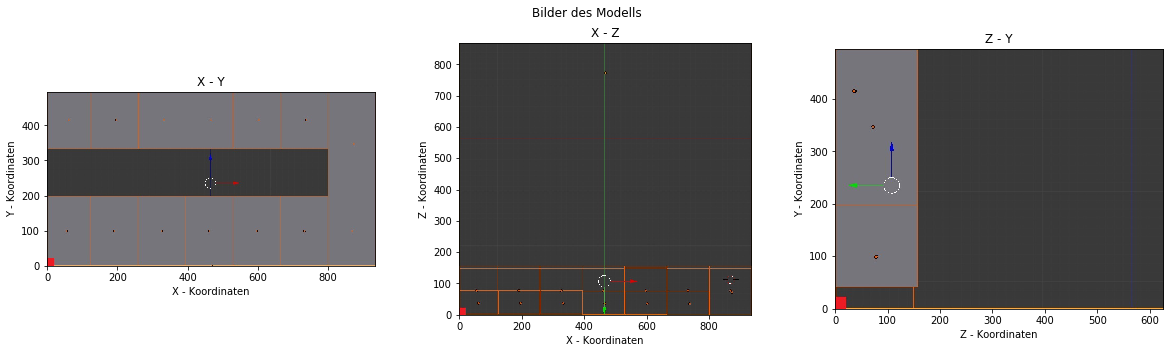

In [9]:
plot_with_image([[],[],[]], 'Bilder des Modells')

Durch das Testen der Werte wird versucht die Transformationsmatrix zu ermitteln. Zuerst werden die Kamerakoordinaten für die Transformation um eine Dimension erweitert.

In [11]:
# Achsen umdrehen: soll -> [[x1,y1,z1],[x2,y2,z2],...] ist -> [[x1,x2,...],[y1,y2,...],[z1,z2,...]]
TEST_COORDS = np.swapaxes(COORDS_FACE, 0, 1) 

# 1 als 4te Dimension (für die Transformation)
TEST_COORDS = np.insert(TEST_COORDS, 3, 1, axis=1) 

Im nächsten Schritt wird nun zunächst versucht die Rotation (der Kamera) zu bestimmten. Dazu werden interaktive Input Felder für die Rotationen (in °) um die Achsen erstellt.

In [13]:
def draw(rx,ry,rz):
    rot_x = rotate_x(math.radians(rx))
    rot_y = rotate_y(math.radians(ry))
    rot_z = rotate_z(math.radians(rz))

    plot(np.swapaxes(TEST_COORDS @ (rot_z @ rot_y @ rot_x).T, 0, 1), 'Rotierte Koordinaten')

interactive_plot = interactive(
    draw,
    rx=(-180, 180),
    ry=(-180, 180),
    rz=(-180, 180)
)

output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot

interactive(children=(IntSlider(value=0, description='rx', max=180, min=-180), IntSlider(value=0, description=…

Es werden folgende Rotationen festgelegt:
- X-Achse: -8°
- Y-Achse: 21°
- Z-Achse: 11°

Die X und Z Achsen sind noch vertauscht.

In [14]:
    # Werte festhalten (in °)
ROT_X_VAL = -8
ROT_Y_VAL = 21
ROT_Z_VAL = 11

ROT_X = rotate_x(math.radians(ROT_X_VAL))
ROT_Y = rotate_y(math.radians(ROT_Y_VAL))
ROT_Z = rotate_z(math.radians(ROT_Z_VAL))

TEST_ROT = ROT_Z @ ROT_Y @ ROT_X

Als nächstes wird versucht die Skalierung zu bestimmen. Dazu werden wiederum interaktive Inputs erstellt. Die ermittelten Testwerte für die Rotationen werden hier mit in die Transformationsmatrix miteinbezogen.

In [16]:
def draw(sx, sy, sz):
    s_x = scale_x(sx)
    s_y = scale_y(sy)
    s_z = scale_z(sz)

    plot(np.swapaxes(TEST_COORDS @ (s_z @ s_y @ s_x @ TEST_ROT).T, 0, 1), 'Skalierte Koordinaten')

interactive_plot = interactive(
    draw,
    sx=FloatSlider(min=-0.01, max=1, step=0.01, value=1),
    sy=FloatSlider(min=-0.01, max=1, step=0.01, value=1),
    sz=FloatSlider(min=-0.01, max=1, step=0.01, value=1)
)
output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot

interactive(children=(FloatSlider(value=1.0, description='sx', max=1.0, min=-0.01, step=0.01), FloatSlider(val…

Durch die Skalierung mit dem Faktor 0.4 werden ungefähr die Pixeldimensionen (X x Y = 935 x 496) erreicht. (Die X und Z Achsen sind noch vertauscht)

In [17]:
# Werte festhalten
S_X_VAL = 0.4
S_Y_VAL = 0.4
S_Z_VAL = 0.4

S_X = scale_x(S_X_VAL)
S_Y = scale_y(S_Y_VAL)
S_Z = scale_z(S_Z_VAL)

TEST_SCALE = S_Z @ S_Y @ S_X

Mit dem nachfolgenden interaktiven Input wird versucht die Verschiebung zu ermitteln.

In [19]:
temp_translation = TEST_SCALE @ TEST_ROT

def draw(dx, dy, dz):
    d = translate(dx, dy, dz)
    
    plot(np.swapaxes(TEST_COORDS @ (d @ temp_translation).T, 0, 1), 'Verschobene Koordinaten')

interactive_plot = interactive(
    draw,
    dx=IntSlider(min=-1000, max=1000, step=1, value=0),
    dy=IntSlider(min=-1000, max=1000, step=1, value=0),
    dz=IntSlider(min=-1000, max=1000, step=1, value=0),
)
output = interactive_plot.children[-1]
output.layout.height = '320px'
interactive_plot

interactive(children=(IntSlider(value=0, description='dx', max=1000, min=-1000), IntSlider(value=0, descriptio…

Als Werte für die Verschiebung wird festgehalten:
- X-Achse: 200
- Y-Achse: 400
- Z-Achse: 25

Abschließend muss noch die Vertauschung der Z und X-Achse korrigiert werden.

In [20]:
def get_transformation_matrix():
    rot_x = rotate_x(math.radians(-8))
    rot_y = rotate_y(math.radians(21))
    rot_z = rotate_z(math.radians(11))

    s_x = scale_x(0.4)
    s_y = scale_y(0.4)
    s_z = scale_z(0.4)

    d = translate(200, 400, 25)

    rot_ax = rotate_y(math.radians(-90))
    swap_ax = scale_x(-1)
    
    return swap_ax @ rot_ax @ d @ s_z @ s_y @ s_x @ rot_z @ rot_x @ rot_y

Zum Test der errechneten Transformationsmatrix wird diese auf den Ursprung angewendet, um die Kameraposition und -rotation darzustellen. Die Z-Achse der Kamera ist blau, die X-Achse rot und die Y-Achse grün. Es wird jeweils nur der positive Anteil der Achse angezeigt.

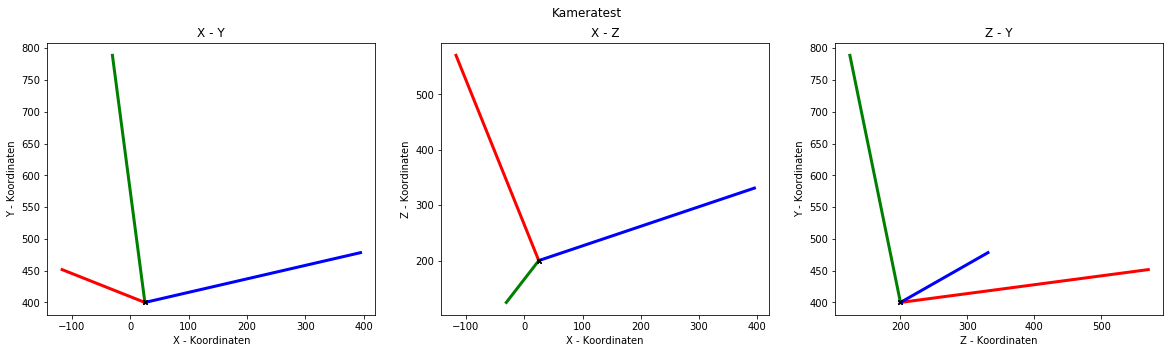

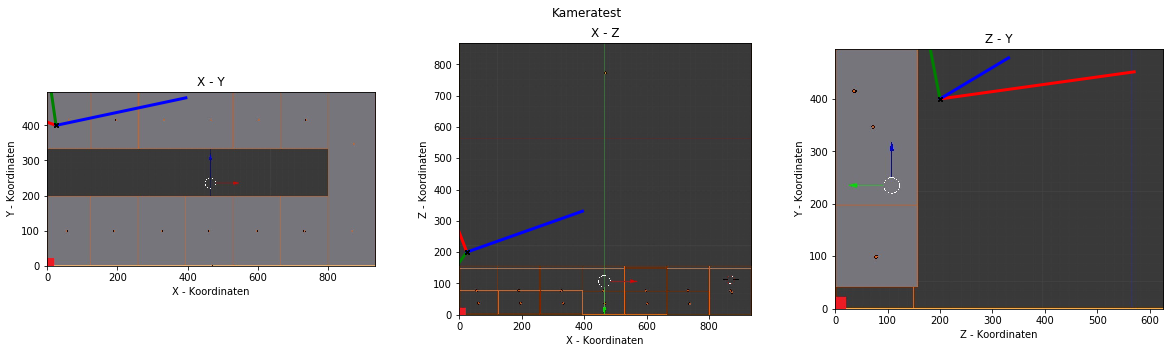

In [21]:
tr = get_transformation_matrix()

coordinates = np.array([[0, 0, 0, 1], [0, 0, 0, 1], [0, 0, 0, 1]], dtype=float)
axes = np.array([[1000, 0, 0, 1], [0, 1000, 0, 1], [0, 0, 1000, 1]], dtype=float)
colors = [['r', 'k'], ['g', 'k'], ['b', 'k']]

coordinates = coordinates @ tr.T
axes = axes @ tr.T
    
coordinates = np.delete(coordinates, 3, axis=1)
axes = np.delete(axes, 3, axis=1)

plot_vectors(np.swapaxes(coordinates, 0, 1), np.swapaxes(axes, 0, 1), 'Kameratest', colors=colors, line_width=3)
plot_vectors_with_image(np.swapaxes(coordinates, 0, 1), np.swapaxes(axes, 0, 1), 'Kameratest', colors=colors, line_width=3)

Die Koordinaten und Blicke werden jetzt mit der errechneten Transformationsmatrix umgerechnet und im Koordinatensystem des Modells dargestellt.

In [22]:
# Normalisieren eines Vektors
def normalize(x):
    return x / np.linalg.norm(x)

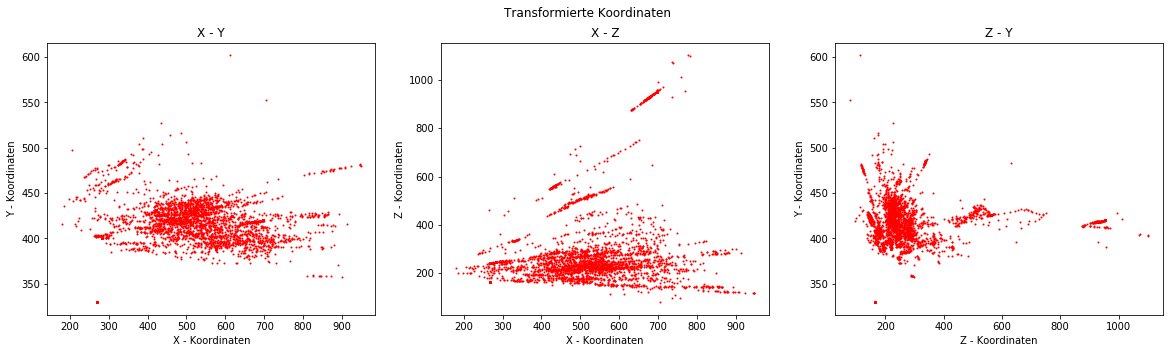

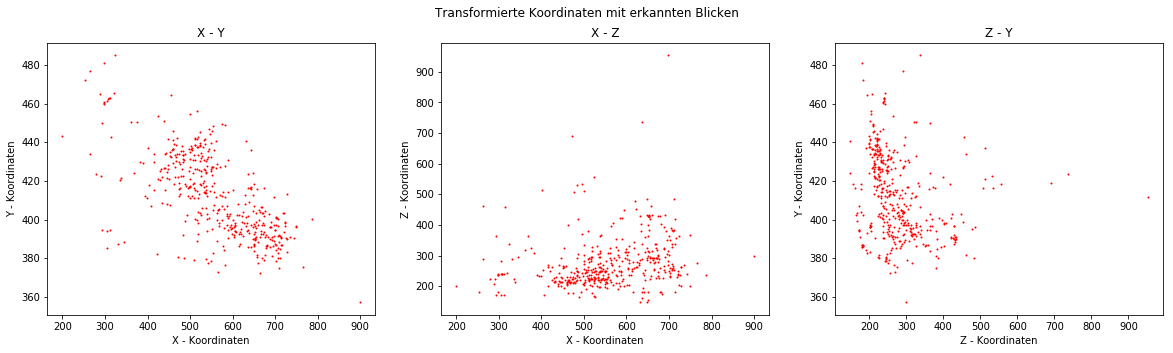

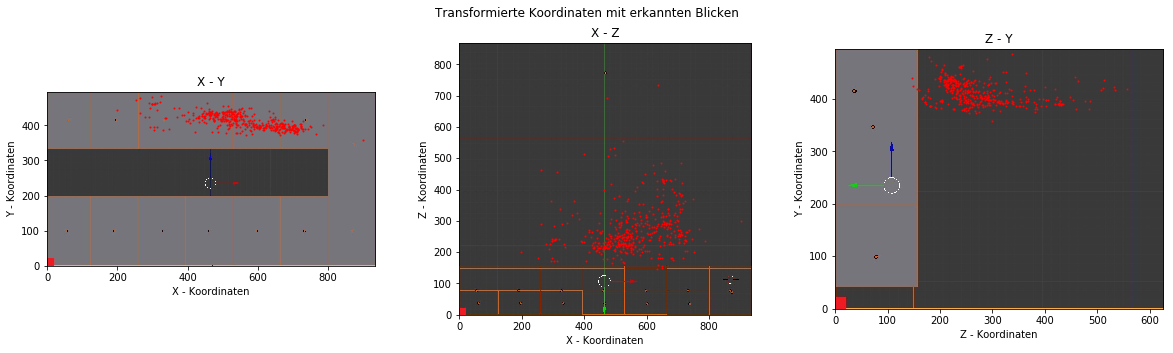

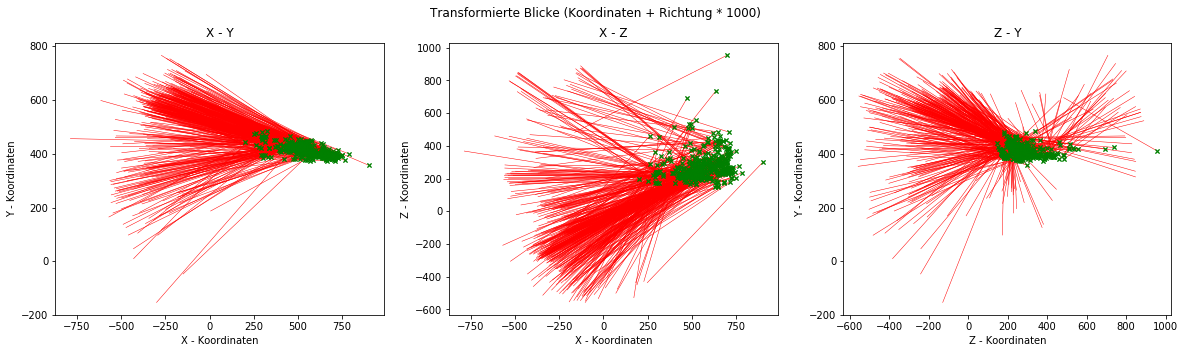

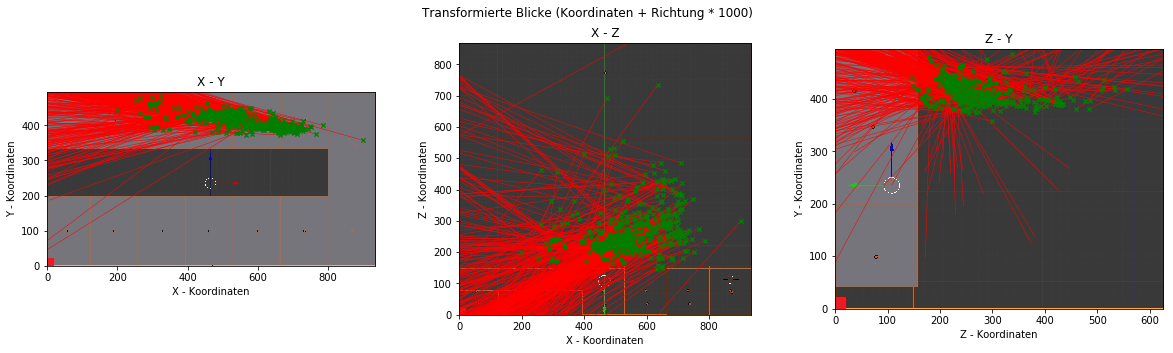

In [25]:
tr = get_transformation_matrix()

def apply_transfromation(x, swap=True):
    x = np.swapaxes(x, 0, 1)

    # Dimension erweitern für Transformation
    x = np.insert(x, 3, 1, axis=1)
    x = x @ tr.T
    
    x = np.delete(x, 3, axis=1)
    if swap:
        return np.swapaxes(x, 0, 1)
    else:
        return x

### Erster Plot ###
plot(apply_transfromation(COORDS_FACE), 'Transformierte Koordinaten')

### Zweiter Plot ###
plot(apply_transfromation(COORDS_GAZE), 'Transformierte Koordinaten mit erkannten Blicken')
plot_with_image(apply_transfromation(COORDS_GAZE), 'Transformierte Koordinaten mit erkannten Blicken')

### Dritter Plot ###
gaze_ends = np.swapaxes(np.swapaxes(COORDS_GAZE, 0, 1) + np.swapaxes(GAZES, 0, 1), 0, 1)

coords = apply_transfromation(COORDS_GAZE, swap=False)
gaze_ends = apply_transfromation(gaze_ends, swap=False)

directions = gaze_ends - coords
directions = np.array([normalize(directions[i]) for i in range(len(directions))])

gaze_ends = coords + directions * 1000

coords = np.swapaxes(coords, 0, 1)
gaze_ends = np.swapaxes(gaze_ends, 0, 1)

plot_vectors(coords, gaze_ends, 'Transformierte Blicke (Koordinaten + Richtung * 1000)')
plot_vectors_with_image(coords, gaze_ends, 'Transformierte Blicke (Koordinaten + Richtung * 1000)')

## Erste Auswertung

Für eine erste Auswertung werden zunächst AOIs und benötigte Funktionen definiert.

In [26]:
class AOI(object):
    '''
    P1-----------P2
    |             |
    |             |
    P3-----------P4
    
    v1: P1--->P2
    v2: P1--->P3
    
    x: min x 
    y: min y 
    z: min z 
    
    w: x dim
    h: y dim
    d: z dim
    
    points: gaze hits
    '''
    def __init__(self, p1, p2, p3, color, title):
        self.title = title
        self.color = color
        self.p1 = np.array(p1, dtype=float)
        self.p2 = np.array(p2, dtype=float)
        self.p3 = np.array(p3, dtype=float)
        self.v1 = np.array(self.p2 - self.p1, dtype=float)
        self.v2 = np.array(self.p3 - self.p1, dtype=float)
        self.p4 = np.array(self.p1 + self.v1 + self.v2, dtype=float)
        self.n = np.array(np.cross(self.v1, self.v2), dtype=float)
        self.x = min(self.p1[0], self.p2[0], self.p3[0], self.p4[0])
        self.y = min(self.p1[1], self.p2[1], self.p3[1], self.p4[1])
        self.z = min(self.p1[2], self.p2[2], self.p3[2], self.p4[2])
        self.w = max(self.p1[0], self.p2[0], self.p3[0], self.p4[0]) - self.x
        self.h = max(self.p1[1], self.p2[1], self.p3[1], self.p4[1]) - self.y
        self.d = max(self.p1[2], self.p2[2], self.p3[2], self.p4[2]) - self.z
        self.points = []

Als AOIs werden die *oberen Schränke*, die *Wand zwischen den oberen und unteren Schränken*, die *unteren Schränke*, die *komplette Arbeitsfläche (inkl. Herd)* und der *Kühlschrank* definiert.

In [27]:
def get_aois():
    schrank_oben = AOI([0, 330, 75], [800, 330, 75], [0, 496, 75], 'orange', 'Schrank oben')
    wand = AOI([0, 330, 1], [0, 200, 1], [800, 330, 1], 'blue', 'Wand zwischen Schränken')
    schrank_unten = AOI([0, 200, 156], [800, 200, 156], [0, 0, 156], 'white', 'Schrank unten')
    af = AOI([0, 200, 0], [800, 200, 0], [0, 200, 156], 'green', 'Arbeitsfläche')
    ks = AOI([800, 0, 156], [935, 0, 156], [800, 496, 156], 'cyan', 'Kühlschrank')
    
    return [schrank_oben, wand, schrank_unten, ks, af]

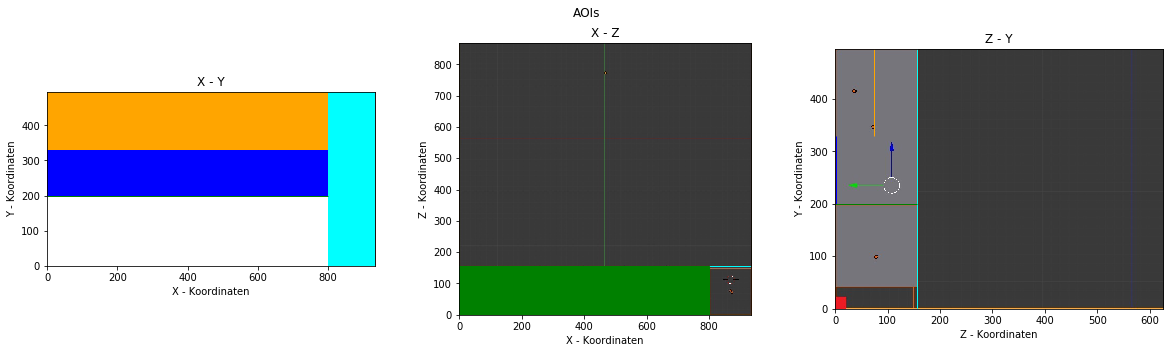

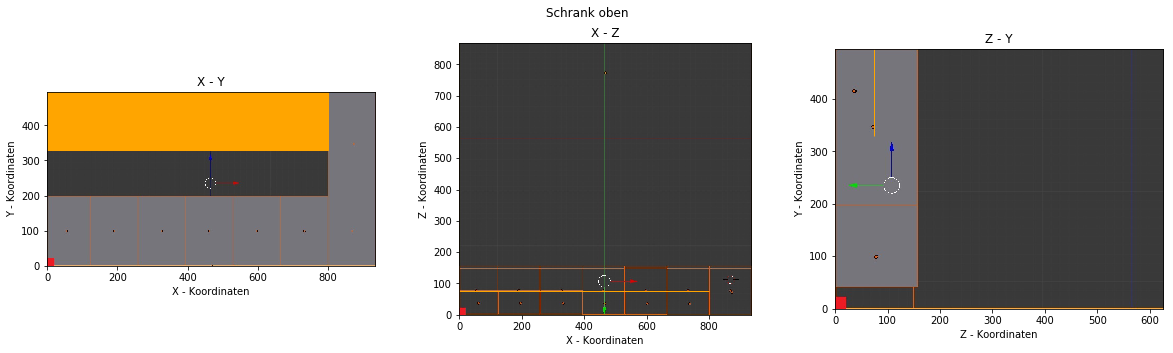

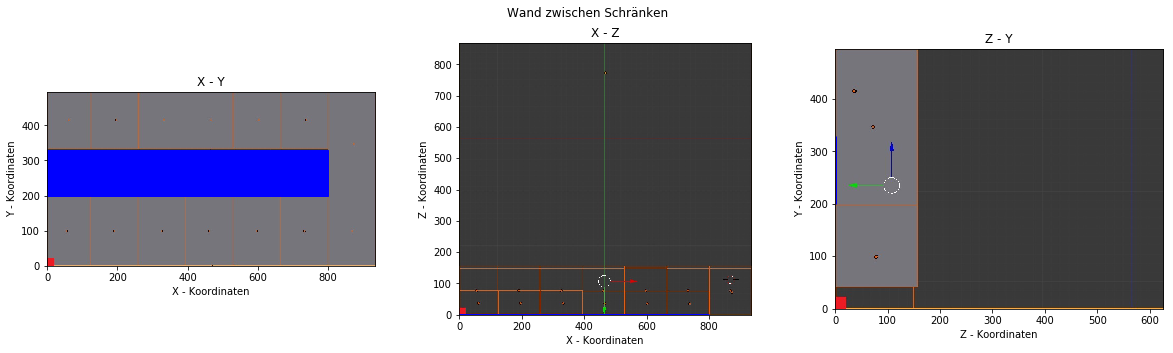

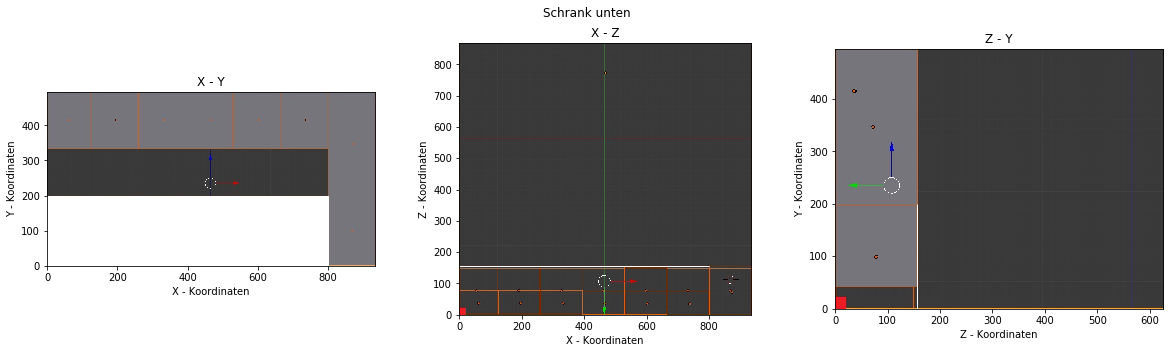

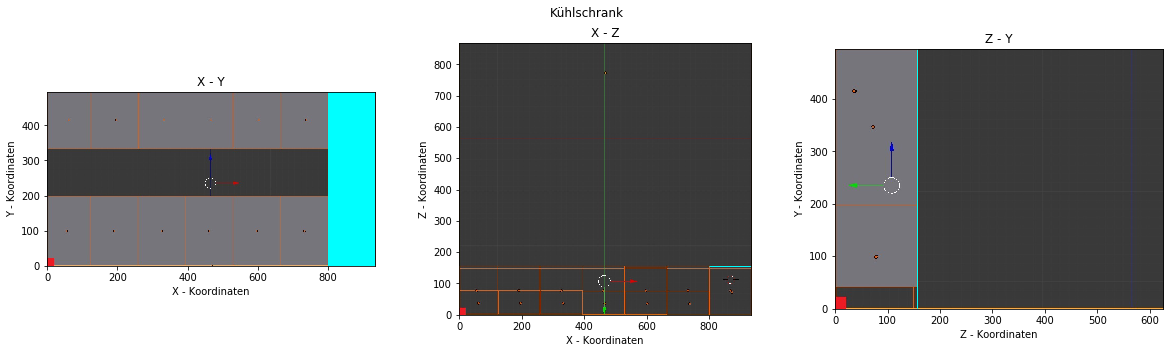

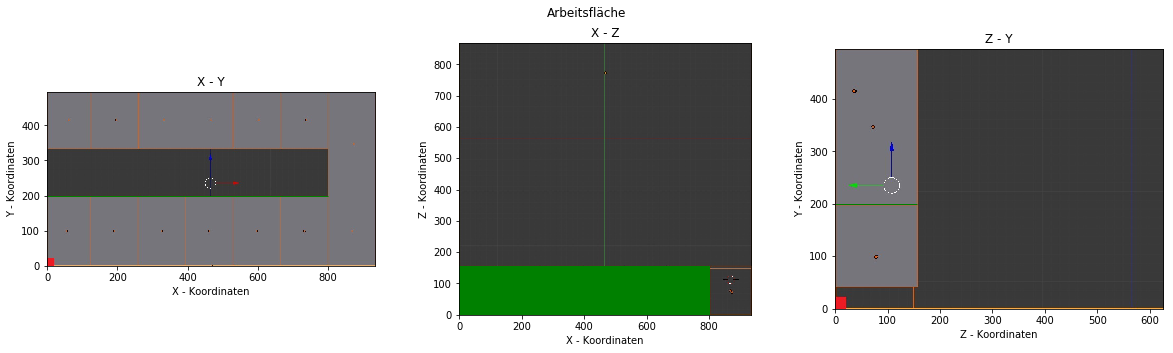

In [28]:
aois = get_aois()

plot_vectors_with_image_and_aois([[],[],[]], [[],[],[]], get_aois(), 'AOIs')

for aoi in aois:
    plot_heatmap(aoi, aoi.title)

Für die Berechnung der Heatmap und der Blicke auf die AOIs werden eine Hilfsklasse und Hilfsfunktionen erstellt.

In [30]:
class Intersection(object):
    def __init__(self, start, direction, aoi):
        self.start = start
        self.direction = normalize(direction)
        self.aoi = aoi
        self.distance = intersect_plane(self.start, direction, self.aoi.p1, normalize(self.aoi.n))
        self.end = self.start + self.distance * self.direction
        self.hit_x = False
        self.hit_y = False
        self.hit_z = False
        self.is_hit = False
        self.hit()
        
    def hit(self):
        if self.end[0] >= self.aoi.x - 1 and self.end[0] <= self.aoi.x + self.aoi.w + 1:
            self.hit_x = True
        if self.end[1] >= self.aoi.y - 1 and self.end[1] <= self.aoi.y + self.aoi.h + 1:
            self.hit_y = True
        if self.end[2] >= self.aoi.z - 1 and self.end[2] <= self.aoi.z + self.aoi.d + 1:
            self.hit_z = True
        if self.hit_z and self.hit_y and self.hit_x:
            self.is_hit = True
        else:
            self.distance = np.inf
            self.is_hit = False
            
    def get_target(self):
        return self.start + self.direction * self.distance

# siehe: https://gist.github.com/rossant/6046463
def intersect_plane(O, D, P, N):
    # Return the distance from O to the intersection of the ray (O, D) with the 
    # plane (P, N), or +inf if there is no intersection.
    # O and P are 3D points, D and N (normal) are normalized vectors.
    denom = np.dot(D, N)
    if np.abs(denom) < 1e-6:
        return np.inf
    d = np.dot(P - O, N) / denom
    if d < 0:
        return np.inf
    return d

def aoi_to_point_and_normal(aoi):
    return aoi.p1, normalize(aoi.n)

def aois_to_point_and_normal(aois):
    return np.array([aoi_to_point_and_normal(aoi) for aoi in aois])

def intersect_aoi(start, direction, aoi):
    return intersect_plane(start, normalize(direction), aoi.p1, normalize(aoi.n))

def intersect_aois(start, direction, aois):
    return np.array([intersect_plane(start, normalize(direction), aoi.p1, normalize(aoi.n)) for aoi in aois])

def get_distances_to_aois(start_points, direction_vectors, aois):
    return np.array([intersect_aois(start_points[i], direction_vectors[i], aois) for i in range(len(start_points))])

def get_intersection_point(start, direction, distance):
    if distance < np.inf:
        return np.array(start + normalize(direction) * distance)
    else:
        return start
    
def get_single_aoi_intersection(start, direction, aoi):
    return Intersection(start, direction, aoi)

def get_single_aois_intersection(start, direction, aois):
    return np.array([Intersection(start, direction, aoi) for aoi in aois])

def get_all_aois_intersection(start_points, directions, aois):
    return np.array([get_single_aois_intersection(start_points[i], directions[i], aois) for i in range(len(start_points))])
        
def set_closest_intersection_and_get_distance(intersections):
    closest = min(intersections, key=lambda x: x.distance)
    if closest.distance < np.inf:
        closest.aoi.points.append(closest.get_target())
    return closest.distance

def get_gaze_pairs(coords, directions, distances):
    start_list = []
    end_list = []
    for i in range(len(coords)):
        if distances[i] < np.inf:
            start_list.append(coords[i])
            end_list.append(coords[i] + normalize(directions[i]) * distances[i])
    return np.array(start_list), np.array(end_list)

Die Blicke werden zusammen mit den Koordinaten in das Zielkoordinatensystem transformiert.

In [31]:
coords = COORDS_GAZE
directions = GAZES

# normierte Blickrichtung auf Startkoordinaten addieren
gaze_ends = np.swapaxes(np.swapaxes(coords, 0, 1) + np.swapaxes(directions, 0, 1), 0, 1)

# transformieren
TRANSFORMED_COORDS_GAZE = apply_transfromation(COORDS_GAZE, swap=False)
gaze_ends = apply_transfromation(gaze_ends, swap=False)

# Blickrichtung zurückrechnen und normalisieren
directions = gaze_ends - TRANSFORMED_COORDS_GAZE
TRANSFORMED_GAZES = np.array([normalize(directions[i]) for i in range(len(directions))])

Die Vektoren mit den transformierten Startkoordinaten und Richtungen werden mit den definierten AOIs gekreuzt. Es wird der erste Schnittpunkt (falls vorhanden) ermittelt. Dieser wird dann zur AOI hinzugefügt.

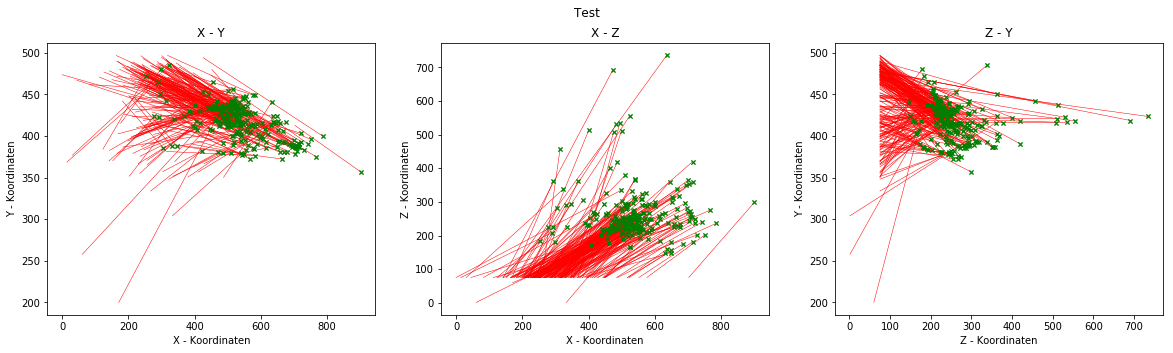

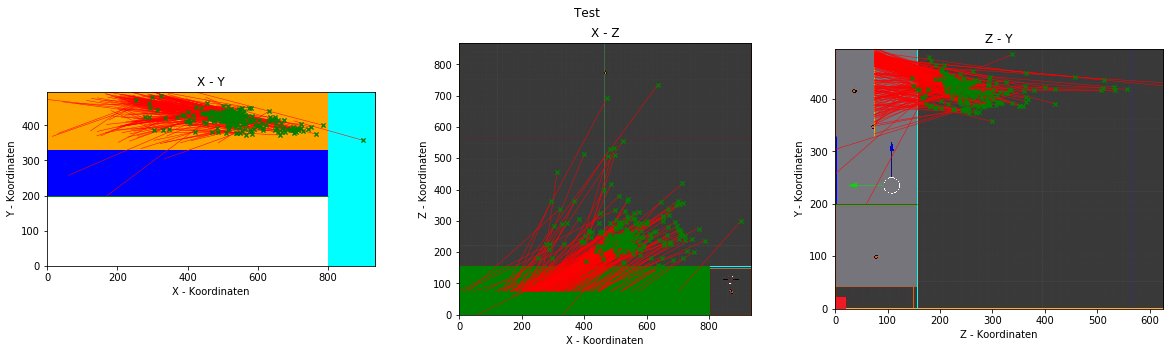

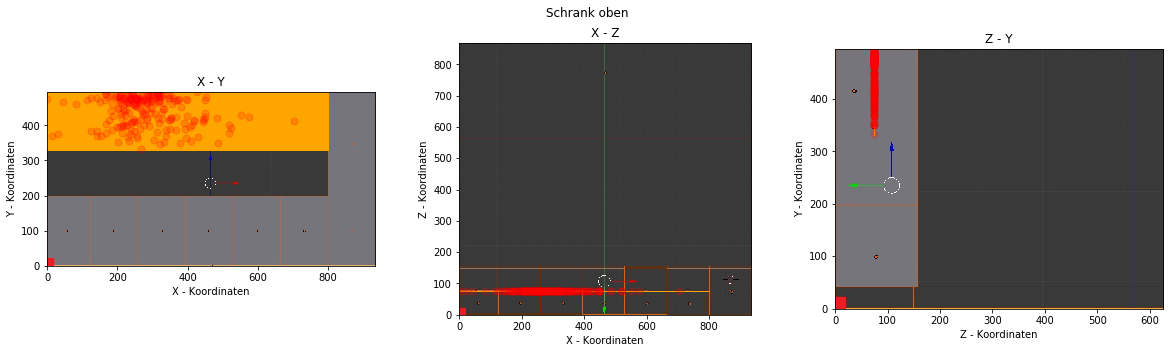

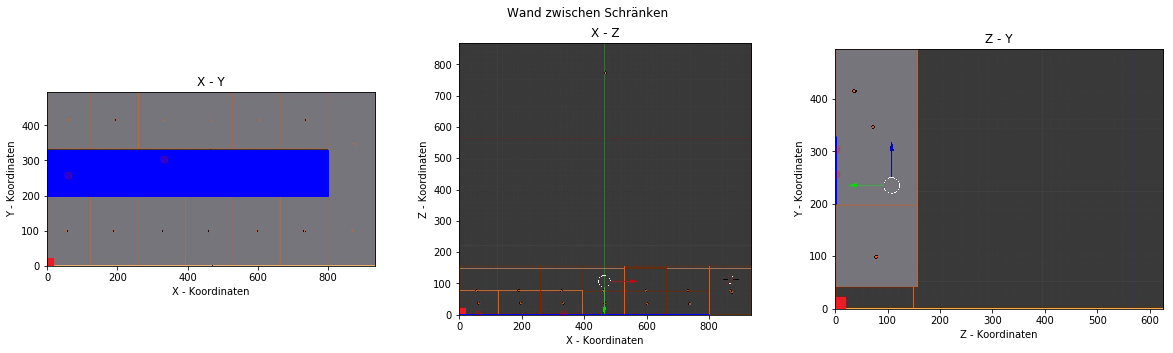

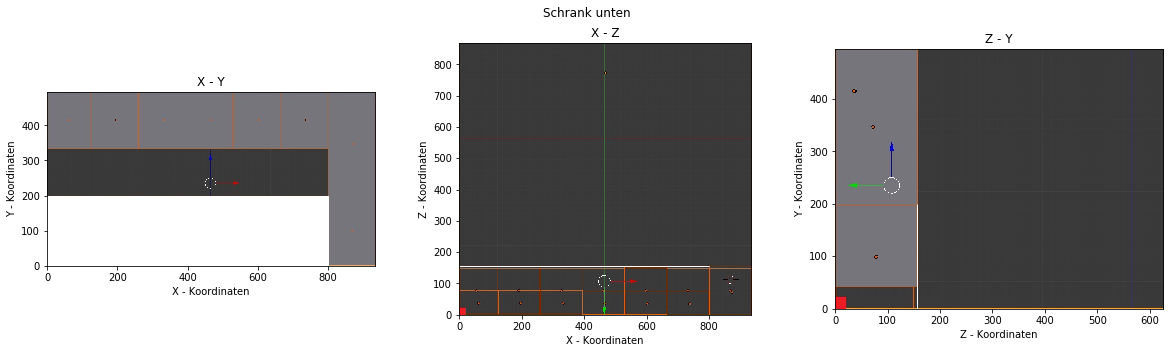

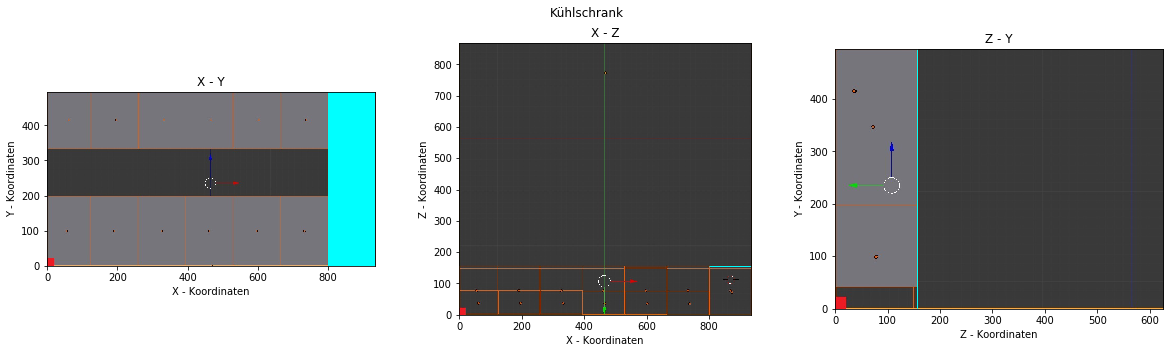

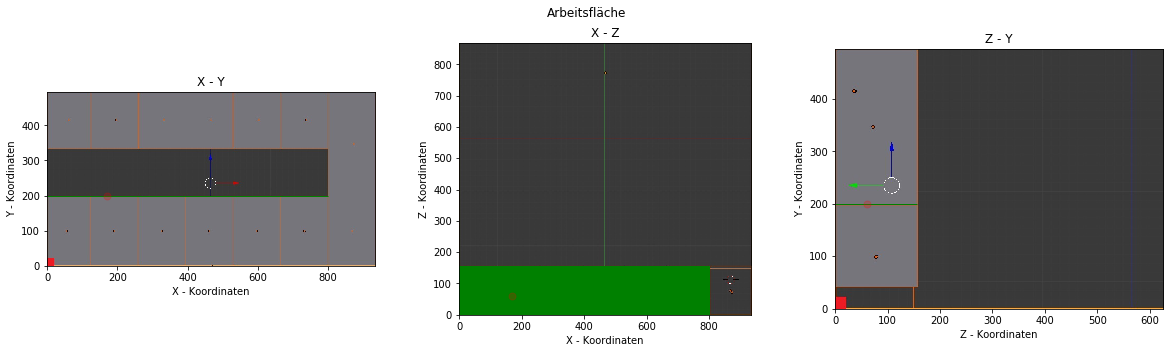

In [32]:
aois = get_aois()

# Intersektion Ojekte erstellen
intersections = get_all_aois_intersection(TRANSFORMED_COORDS_GAZE, TRANSFORMED_GAZES, aois)

# Kürzeste Entfernung für jeden Punkt
distances = np.array([set_closest_intersection_and_get_distance(intersections[i]) for i in range(len(intersections))])

# Start- und Endpunkte der Blicke (Start = Ende, wenn kein Schnittpunkt => Entfernung INF)
coords, gaze_end = get_gaze_pairs(TRANSFORMED_COORDS_GAZE, TRANSFORMED_GAZES, distances)

coords = np.swapaxes(coords, 0, 1)
gaze_end = np.swapaxes(gaze_end, 0, 1)

plot_vectors(coords, gaze_end, 'Test')
plot_vectors_with_image_and_aois(coords, gaze_end, aois, 'Test')

for aoi in aois:
    plot_heatmap(aoi, aoi.title)